In [1]:
import torch
import sys
import pandas as pd
from tqdm.auto import tqdm
from pathlib import Path
from transformers import AutoModelForSequenceClassification, AutoTokenizer
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix

/Users/ujjwalpoudel/Documents/insane_projects/Conversational-Health-Analytics-/.newvenv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
sys.path.append(str(Path.cwd().parents[2] / "src"))
from preprocessing.preprocess_dataset import DistilBertPreprocessor

import seaborn as sns
import matplotlib.pyplot as plt

[nltk_data] Downloading package punkt to
[nltk_data]     /Users/ujjwalpoudel/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     /Users/ujjwalpoudel/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


In [3]:
# CONFIGURATION
CHECKPOINT_PATH = Path.cwd().parents[2] / "models" / "distilbert-v4"
DATA_DIR = Path("/Volumes/MACBACKUP/final_datasets/")
TEST_DATA_PATH = DATA_DIR / "final_test_dataset.csv"

In [4]:
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
model = AutoModelForSequenceClassification.from_pretrained(CHECKPOINT_PATH)
tokenizer = AutoTokenizer.from_pretrained(CHECKPOINT_PATH)
model.to(device)
model.eval()

DistilBertForSequenceClassification(
  (distilbert): DistilBertModel(
    (embeddings): Embeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.2, inplace=False)
    )
    (transformer): Transformer(
      (layer): ModuleList(
        (0-5): 6 x TransformerBlock(
          (attention): MultiHeadSelfAttention(
            (dropout): Dropout(p=0.3, inplace=False)
            (q_lin): Linear(in_features=768, out_features=768, bias=True)
            (k_lin): Linear(in_features=768, out_features=768, bias=True)
            (v_lin): Linear(in_features=768, out_features=768, bias=True)
            (out_lin): Linear(in_features=768, out_features=768, bias=True)
          )
          (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (ffn): FFN(
            (dropout): Dropout(p=0.2, inplace=False)
 

In [5]:
# Load and preprocess test data
preprocessor = DistilBertPreprocessor()
print("Loading and preprocessing test data...")
X_test_df, y_test_df = preprocessor.load_and_preprocess(TEST_DATA_PATH, keep_id_column=True)
X_test_chunked, y_test_chunked = preprocessor.chunk_dataframe(X_test_df, y_test_df)

/Users/ujjwalpoudel/Documents/insane_projects/Conversational-Health-Analytics-/.newvenv/lib/python3.11/site-packages/huggingface_hub/file_download.py:945: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Loading and preprocessing test data...
Successfully loaded /Volumes/MACBACKUP/final_datasets/final_test_dataset.csv. Found 47 records.
Text cleaning complete.
Data prepared. X shape: (47, 2), y shape: (47, 1)

Starting chunking with strategy: 'sentence_aware'...


Token indices sequence length is longer than the specified maximum sequence length for this model (1725 > 512). Running this sequence through the model will result in indexing errors


Chunking complete. Original docs: 47, Total chunks: 206


In [6]:
# Get predictions for each chunk
print("Getting predictions for each text chunk...")
chunk_predictions = []
with torch.no_grad():
    for index, row in tqdm(X_test_chunked.iterrows(), total=len(X_test_chunked)):
        text = row['text']
        participant_id = row['participant_id']

        inputs = tokenizer(text, return_tensors="pt", truncation=True, padding=True).to(device)
        outputs = model(**inputs)
        probs = torch.softmax(outputs.logits, dim=-1)
        prob_class_1 = probs[0][1].item()
        predicted_label = torch.argmax(probs, dim=-1).item()

        chunk_predictions.append({
            'participant_id': participant_id,
            'chunk_probability': prob_class_1,
            'chunk_prediction': predicted_label
        })

Getting predictions for each text chunk...


  0%|          | 0/206 [00:00<?, ?it/s]huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
100%|██████████| 206/206 [00:08<00:00, 23.10it/s]


In [7]:
chunk_results_df = pd.DataFrame(chunk_predictions)
true_labels_df = X_test_df.join(y_test_df)[['participant_id', 'label']]

### Aggregation Methods

In [8]:
# Majority Voting
voting_preds_df = (
    chunk_results_df.groupby('participant_id')['chunk_prediction']
    .agg(lambda x: x.mode()[0])
    .reset_index()
    .rename(columns={'chunk_prediction': 'final_prediction'})
)

In [9]:
# Max Pooling
max_prob_series = chunk_results_df.groupby('participant_id')['chunk_probability'].agg('max')
max_pool_preds_df = pd.DataFrame({
    'participant_id': max_prob_series.index,
    'final_prediction': (max_prob_series > 0.5).astype(int)
}).reset_index(drop=True)

In [10]:
# Average Pooling
avg_prob_series = chunk_results_df.groupby('participant_id')['chunk_probability'].mean()
avg_pool_preds_df = pd.DataFrame({
    'participant_id': avg_prob_series.index,
    'final_prediction': (avg_prob_series > 0.5).astype(int)
}).reset_index(drop=True)

In [11]:
def evaluate_method(method_name, preds_df):
    results_df = pd.merge(preds_df, true_labels_df, on='participant_id')
    true_labels = results_df['label']
    final_predictions = results_df['final_prediction']

    report = classification_report(true_labels, final_predictions, target_names=['Not Depressed (0)', 'Depressed (1)'])
    accuracy = accuracy_score(true_labels, final_predictions)
    cm = confusion_matrix(true_labels, final_predictions)

    print("\n" + "="*70)
    print(f"{method_name.upper()} RESULTS")
    print("="*70)
    print(f"\nAccuracy: {accuracy:.4f}\n")
    print("Classification Report:")
    print(report)

    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=['Not Depressed (0)', 'Depressed (1)'],
                yticklabels=['Not Depressed (0)', 'Depressed (1)'])
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.title(f"Confusion Matrix ({method_name})")
    plt.show()


MAJORITY VOTING RESULTS

Accuracy: 0.6170

Classification Report:
                   precision    recall  f1-score   support

Not Depressed (0)       0.69      0.82      0.75        33
    Depressed (1)       0.25      0.14      0.18        14

         accuracy                           0.62        47
        macro avg       0.47      0.48      0.47        47
     weighted avg       0.56      0.62      0.58        47



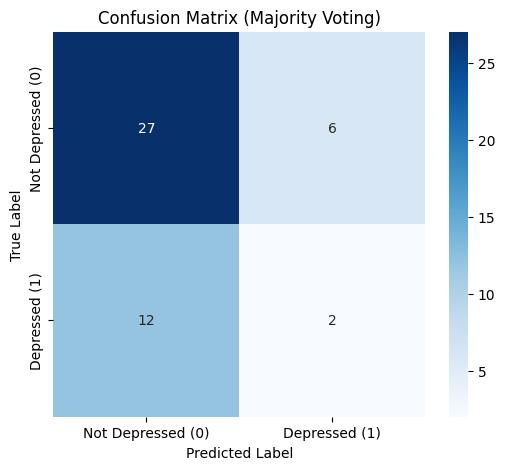


MAX POOLING RESULTS

Accuracy: 0.4681

Classification Report:
                   precision    recall  f1-score   support

Not Depressed (0)       0.70      0.42      0.53        33
    Depressed (1)       0.30      0.57      0.39        14

         accuracy                           0.47        47
        macro avg       0.50      0.50      0.46        47
     weighted avg       0.58      0.47      0.49        47



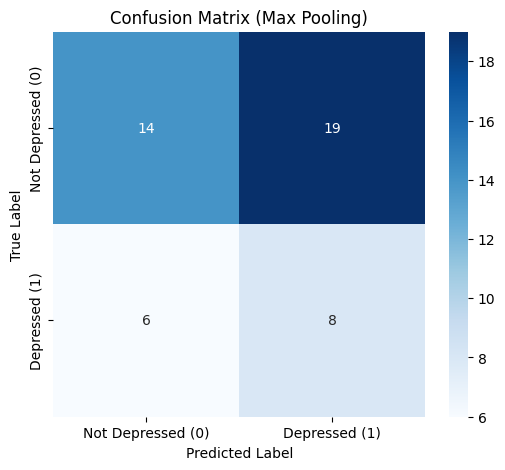


AVERAGE POOLING RESULTS

Accuracy: 0.6809

Classification Report:
                   precision    recall  f1-score   support

Not Depressed (0)       0.74      0.85      0.79        33
    Depressed (1)       0.44      0.29      0.35        14

         accuracy                           0.68        47
        macro avg       0.59      0.57      0.57        47
     weighted avg       0.65      0.68      0.66        47



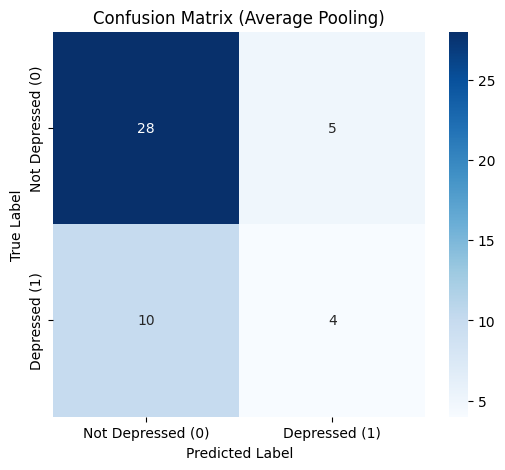

In [12]:
evaluate_method("Majority Voting", voting_preds_df)
evaluate_method("Max Pooling", max_pool_preds_df)
evaluate_method("Average Pooling", avg_pool_preds_df)